# Projeto — Perfumes & Psicofisiologia

**Objetivo:** O presente relatório tem como objetivo apresentar uma análise completa do dataset Perfume & Psychology, que reúne informações extraídas de literatura científica sobre materiais odorantes, seus componentes químicos, alterações psicofisiológicas descritas em textos e funções cerebrais ativadas. O estudo foi conduzido com o intuito de aplicar técnicas avançadas de ciência de dados, envolvendo limpeza, integração, análise exploratória, testes estatísticos, modelagem preditiva e otimização.
A investigação se fundamenta na hipótese principal de que perfumes que ativam mais funções cerebrais demandariam descrições psicofisiológicas mais longas, sugerindo maior complexidade neuropsicológica. Com base nisso, métodos de correlação e análise de variância foram empregados para verificar tal relação, além da implementação de modelos de regressão e classificação para previsão de efeitos psicofisiológicos e alterações em EEG.

**Dataset:** Perfume & Psychology (conjunto composto por `perfume_Brainfunc.csv`, `perfume_compound.csv`, `perfume_Psycho.csv`).

**Hipótese 1 (H4):** Perfumes com maior número de funções cerebrais ativadas possuem textos psicofisiológicos mais longos.

**Hipótese 2 (H1):**  Perfumes com efeitos psicofisiológicos calmantes reduzem a atividade EEG.

**Hipótese 3 (H1):**  Perfumes com mais componentes químicos produzem mudanças EEG mais intensas.

**Variáveis-alvo:**
- Regressão primária: `eeg_change_num` (−1: decrease, 0: no change, 1: increase).
- Classificação: `psych_label` (4 classes).
**Ambiente:** Python (pandas, seaborn, statsmodels, scikit-learn, pycaret opcional).

Seed usada em todo projeto: `42`.


# Setup + Carregamento dos Dados

Este trecho do código inicia o ambiente do projeto configurando bibliotecas, estilo visual, reprodutibilidade e a estrutura de diretórios necessários para armazenar dados, artefatos e figuras. No começo, são importadas bibliotecas essenciais: pandas e numpy para manipulação de dados, matplotlib e seaborn para gráficos, pathlib para gerenciar caminhos, joblib para salvar objetos e random para operações aleatórias. Os warnings são desativados para deixar as saídas mais limpas. Em seguida, seeds globais são definidos para garantir que qualquer operação aleatória produza sempre o mesmo resultado, deixando o projeto reprodutível. Diretórios importantes são configurados: data/Perfume&Psychology como fonte dos datasets, artifacts/ para salvar arquivos gerados durante o processo, e figures/ para armazenar gráficos; esses diretórios são criados automaticamente se ainda não existirem.

Logo após o setup, é definida uma função auxiliar simples chamada load_csv, responsável por localizar e carregar arquivos CSV dentro da pasta de dados do projeto. Ela imprime o nome do arquivo e seu tamanho (linhas × colunas), facilitando o acompanhamento do carregamento. Em seguida, três datasets principais do projeto são carregados: perfume_Brainfunc.csv, contendo medidas de atividade cerebral; perfume_compound.csv, com informações químicas dos perfumes; e perfume_Psycho.csv, com respostas psicológicas dos participantes. Para uma inspeção inicial, são exibidas as primeiras linhas de cada tabela com display(), permitindo verificar rapidamente a estrutura, colunas e possíveis inconsistências antes de seguir com etapas posteriores da análise.

In [10]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
import joblib
import random

random.seed(42)
np.random.seed(42)

ROOT = Path('.').resolve()
DATA_DIR = ROOT / "data" / "Perfume&Psychology"
ART = ROOT / "artifacts"
FIG = ROOT / "figures"
ART.mkdir(exist_ok=True)
FIG.mkdir(exist_ok=True)


def load_csv(name):
    p = DATA_DIR / name
    df = pd.read_csv(p)
    print(f"Loaded {name} -> shape {df.shape}")
    return df


brain = load_csv("perfume_Brainfunc.csv")
comp = load_csv("perfume_compound.csv")
psy = load_csv("perfume_Psycho.csv")

# show heads
display(brain.head())
display(comp.head())
display(psy.head())


Loaded perfume_Brainfunc.csv -> shape (42, 5)
Loaded perfume_compound.csv -> shape (23, 3)
Loaded perfume_Psycho.csv -> shape (38, 4)


,S. No.,Odorant Materials,EEG Wave Changes,Brain Functions,Reference
0,1.0,Galaxolide,Alpha decreased.,Odors produce divided attention even when unde...,[74]
1,2.0,m-Xylene,Alpha increased.,Stimulating and excitatory effects.,[75]
2,3.0,"Birch tar, galbanum, heliotropine, jasmine, la...","Increased theta for birch tar, jasmine, lavend...",Subjects differed in their subjective response...,[80]
3,4.0,"5-α-Androstan-3-one, bangalol, white sapphire,...",Alpha increased.,From more anterior electrodes—related to psych...,[70]
4,5.0,Phenylethyl alcohol and valeric acid,Valeric acid—alpha 2 increased.,Unpleasant odor leads to a cortical deactivation.,[76]


,Plants Name,Botanical Name,Major Components
0,Bergamot,Citrus bergamia,"limonene, linalool, linalyl acetate"
1,Caraway,Carum carvi,"carvone, limonene"
2,Chamomile,Matricaria chamomilla,"α-bisabolol, bisabolol oxide B, (E)-β-farnesen..."
3,Cinnamon,Cinnamomum zeylanicum,"cinnamaldehyde, cinnamyl acetate"
4,Cornmint,Mentha arvensis,"menthol, menthone, isomenthone, menthyl acetate"


,S. No.,Odorant Materials,Psychophysiological Changes,Reference
0,1.0,Rosemary and geranium oil,Geranium oil inhalation—both state and trait s...,[113]
1,2.0,"Ylang-ylang, orange, geranium, cypress, bergam...",Cypress produced favorable impression after ph...,[114]
2,3.0,Orange,"Relaxant effect—lower level of state anxiety, ...",[115]
3,4.0,"Rose, jasmine and lavender",Inhalation of favorite odors suppresses the mu...,[116]
4,5.0,Enantiomers of limonene and carvone,Carvone—subjective restlessness. Prolonged inh...,[120]


# Normalização, Padronização e Identificação da Chave de Junção

Nesta parte do código, é feita a preparação das três bases de dados para garantir consistência e permitir que sejam integradas corretamente. Primeiro, são definidas funções auxiliares: norm_cols, que remove espaços indesejados nos nomes das colunas, e clean_text, que padroniza strings removendo excesso de espaços e garantindo um formato limpo. Essas funções são aplicadas aos dataframes brain, comp e psy para padronizar suas colunas e garantir que operações posteriores não falhem por inconsistências simples de formatação.

Em seguida, o código tenta identificar automaticamente qual coluna de cada dataset representa o nome do odor — a variável que será usada como chave para conectar as três tabelas. A busca é feita examinando todas as colunas e procurando palavras como “odor”, “material”, “plant” ou “name”. Se uma coluna correspondente for encontrada, ela é renomeada para odorant, criando uma padronização comum. Caso contrário, uma coluna vazia odorant é criada para evitar erros futuros.

Após unificar o nome da coluna-chave, o código realiza uma limpeza textual nessa coluna em cada dataset, removendo espaços extras e normalizando as entradas. Isso garante que valores iguais não sejam tratados como diferentes devido a formatação irregular. Por fim, é exibido o número de valores únicos de odorant em cada tabela e também são mostrados os nomes finais das colunas de brain, comp e psy, permitindo verificar se tudo foi padronizado corretamente antes de prosseguir com análises e junções entre as bases.

In [11]:
def norm_cols(df):
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    return df


def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).strip()
    s = re.sub(r"\s+", " ", s)
    return s


brain = norm_cols(brain)
comp = norm_cols(comp)
psy = norm_cols(psy)

# inferir colunas-chave
brain_key = next((c for c in brain.columns if "odor" in c.lower() or "material" in c.lower()), None)
comp_key = next((c for c in comp.columns if "plant" in c.lower() or "name" in c.lower()), None)
psy_key = next((c for c in psy.columns if "odor" in c.lower() or "material" in c.lower()), None)

# renomear para odorant
if brain_key:
    brain = brain.rename(columns={brain_key: 'odorant'})
else:
    brain['odorant'] = ''
if comp_key:
    comp = comp.rename(columns={comp_key: 'odorant'})
else:
    comp['odorant'] = ''
if psy_key:
    psy = psy.rename(columns={psy_key: 'odorant'})
else:
    psy['odorant'] = ''

# limpar strings
brain['odorant'] = brain['odorant'].apply(clean_text)
comp['odorant'] = comp['odorant'].apply(clean_text)
psy['odorant'] = psy['odorant'].apply(clean_text)

print("Unique counts:", len(brain['odorant'].unique()), len(comp['odorant'].unique()), len(psy['odorant'].unique()))
display(brain.columns)
display(comp.columns)
display(psy.columns)


Unique counts: 41 23 32


Index(['S. No.', 'odorant', 'EEG Wave Changes', 'Brain Functions',
       'Reference'],
      dtype='object')

Index(['odorant', 'Botanical Name', 'Major Components'], dtype='object')

Index(['S. No.', 'odorant', 'Psychophysiological Changes', 'Reference'], dtype='object')

# Junção das Bases e Construção do Dataset

Nesta etapa, as três bases previamente padronizadas são finalmente integradas em um único dataset consolidado. A junção é realizada utilizando a coluna odorant, que foi identificada e normalizada anteriormente. O processo começa combinando a base brain com a base psy, utilizando um merge do tipo left, garantindo que todas as observações de atividade cerebral sejam preservadas mesmo que algumas não tenham correspondência psicológica. Em seguida, o resultado dessa junção é novamente combinado com a base comp, também como left merge, incorporando informações químicas sempre que disponíveis.

Esse encadeamento de merges cria um dataframe completo contendo, para cada odor estudado, suas medidas cerebrais, psicológicas e químicas. Após a junção, o código imprime o tamanho final do dataset integrado, permitindo verificar quantas linhas e colunas foram geradas, e exibe as primeiras observações para inspeção visual. Por fim, o dataframe consolidado é salvo em artifacts/df_merged.csv, criando uma versão persistente do dataset unificado para uso posterior em análises, modelagem ou visualizações.Feature engineering robusto (cria eeg_change_num, psych_label, counts)

In [12]:
# Merge brain <- psy <- comp on 'odorant' (left fallback)
df = brain.merge(psy, on='odorant', how='left', suffixes=('_brain', '_psy'))
df = df.merge(comp, on='odorant', how='left')
print("Merged df shape:", df.shape)
display(df.head(8))
df.to_csv(ART / 'df_merged.csv', index=False)


Merged df shape: (44, 10)


,S. No._brain,odorant,EEG Wave Changes,Brain Functions,Reference_brain,S. No._psy,Psychophysiological Changes,Reference_psy,Botanical Name,Major Components
0,1.0,Galaxolide,Alpha decreased.,Odors produce divided attention even when unde...,[74],NaN,NaN,NaN,NaN,NaN
1,2.0,m-Xylene,Alpha increased.,Stimulating and excitatory effects.,[75],NaN,NaN,NaN,NaN,NaN
2,3.0,"Birch tar, galbanum, heliotropine, jasmine, la...","Increased theta for birch tar, jasmine, lavend...",Subjects differed in their subjective response...,[80],NaN,NaN,NaN,NaN,NaN
3,4.0,"5-α-Androstan-3-one, bangalol, white sapphire,...",Alpha increased.,From more anterior electrodes—related to psych...,[70],NaN,NaN,NaN,NaN,NaN
4,5.0,Phenylethyl alcohol and valeric acid,Valeric acid—alpha 2 increased.,Unpleasant odor leads to a cortical deactivation.,[76],NaN,NaN,NaN,NaN,NaN
5,6.0,Lavender and rosemary,Lavender—beta increased. Rosemary—frontal alph...,Lavender—increased drowsiness. Rosemary—increa...,[9],NaN,NaN,NaN,NaN,NaN
6,7.0,"Synthetic odors—almond, chocolate, spearmint, ...",Chocolate odor—less theta activity.,Reduced level of attention.,[59],NaN,NaN,NaN,NaN,NaN
7,8.0,Chewing of marketed gum,Alpha power increased.,Arousal psychosomatic responses.,[77],NaN,NaN,NaN,NaN,NaN


# Engenharia de Atributos para EEG, Psicologia e Composição

Nesta fase, o dataset unificado é recarregado e passa por um conjunto de transformações destinadas a extrair informações numéricas e textuais importantes para análises posteriores. Primeiro, é criada uma função map_eeg que converte descrições qualitativas de mudanças em ondas cerebrais (como “increase”, “reduced”, “no change”) em valores numéricos padronizados: 1 para aumento, -1 para diminuição e 0 para ausência de mudança ou casos não identificados. A coluna original EEG Wave Changes é limpa e transformada usando essa função, gerando a nova variável eeg_change_num. Em paralelo, o texto bruto das mudanças psicofisiológicas é normalizado em uma versão reduzida (psych_label), com letras minúsculas, remoção de caracteres especiais e substituição de valores ausentes por “unknown”. Para enriquecer a análise textual, são criadas métricas simples como psych_text_len (tamanho do texto) e psych_word_count (número de palavras). A composição química e as funções cerebrais também passam por parsing estruturado: tanto Major Components quanto Brain Functions têm seus itens separados por delimitadores comuns (;, ,, /, |), resultando nos contadores compound_count e brainfunc_count, que indicam quantos elementos distintos cada registro possui. Por fim, o dataset enriquecido é salvo como df_features.csv e uma amostra das principais novas variáveis é exibida para conferência.

In [13]:
df = pd.read_csv(ART / 'df_merged.csv')


# robust mapping EEG -> numeric
def map_eeg(s):
    s = str(s).lower()
    inc = ['increase', 'increased', 'enhance', 'enhanced', 'rise', 'up', 'higher', 'augment']
    dec = ['decrease', 'decreased', 'reduce', 'reduced', 'down', 'lower', 'diminish', 'suppressed']
    for t in inc:
        if t in s: return 1
    for t in dec:
        if t in s: return -1
    # check 'no change' patterns
    if 'no change' in s or 'no significant' in s or 'no effect' in s or 'unchanged' in s:
        return 0
    return 0


df['EEG Wave Changes'] = df.get('EEG Wave Changes', '').fillna('').astype(str)
df['eeg_change_num'] = df['EEG Wave Changes'].apply(map_eeg)

# clean psych label
df['Psychophysiological Changes'] = df.get('Psychophysiological Changes', '').fillna('').astype(str)
df['psych_label'] = df['Psychophysiological Changes'].str.lower().str.replace(r'[^a-z0-9 ]', '', regex=True).str.strip()
df['psych_label'] = df['psych_label'].replace({'nan': 'unknown', '': 'unknown', 'none': 'unknown'})

# counts and text features
df['psych_text_len'] = df['Psychophysiological Changes'].astype(str).apply(lambda s: len(s))
df['psych_word_count'] = df['Psychophysiological Changes'].astype(str).apply(lambda s: len(s.split()))
df['Major Components'] = df.get('Major Components', '').fillna('').astype(str)
df['compound_count'] = df['Major Components'].apply(
    lambda s: 0 if s.strip() == '' else len([p for p in re.split(r'[;,/|]+', s) if p.strip()]))
df['Brain Functions'] = df.get('Brain Functions', '').fillna('').astype(str)
df['brainfunc_count'] = df['Brain Functions'].apply(
    lambda s: 0 if s.strip() == '' else len([p for p in re.split(r'[;,/|]+', s) if p.strip()]))

# save
df.to_csv(ART / 'df_features.csv', index=False)
print("Features saved, shape:", df.shape)
display(df[['odorant', 'psych_label', 'eeg_change_num', 'psych_text_len', 'psych_word_count', 'compound_count',
            'brainfunc_count']].head(10))


Features saved, shape: (44, 16)


,odorant,psych_label,eeg_change_num,psych_text_len,psych_word_count,compound_count,brainfunc_count
0,Galaxolide,unknown,-1,0,0,0,1
1,m-Xylene,unknown,1,0,0,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",unknown,1,0,0,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",unknown,1,0,0,0,1
4,Phenylethyl alcohol and valeric acid,unknown,1,0,0,0,1
5,Lavender and rosemary,unknown,1,0,0,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",unknown,0,0,0,0,1
7,Chewing of marketed gum,unknown,1,0,0,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",unknown,1,0,0,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",unknown,-1,0,0,0,1


# Análises Estatísticas, Visualizações e Testes de Hipóteses

Nesta etapa, o dataset enriquecido é recarregado e submetido a um conjunto de análises estatísticas para investigar possíveis relações entre características textuais, químicas e funcionais dos odores. Inicialmente, são exibidas as contagens de classes da variável psicológica (psych_label) e também a distribuição numérica das mudanças de EEG (eeg_change_num), permitindo verificar rapidamente como as categorias estão distribuídas. Em seguida, é formulada uma hipótese (H4) avaliando se o número de funções cerebrais associadas a um odor (brainfunc_count) está relacionado ao tamanho do texto psicofisiológico (psych_text_len). Para isso, é gerado um gráfico de dispersão com linha de regressão e salvo em figures/, proporcionando uma visualização clara da tendência entre as variáveis. Estatisticamente, a correlação de Spearman é calculada, sendo apropriada para dados discretos e relações não lineares, resultando em um valor rho e um p-valor que indicam a força e significância da associação. Para complementar, os valores de brainfunc_count são agrupados em faixas (0, 1, 2 e 3+), e um teste ANOVA é aplicado para verificar diferenças de médias de psych_text_len entre esses grupos. Uma visualização adicional é criada através de um boxplot, destacando variações entre os buckets e contribuindo para uma interpretação visual da dispersão e possíveis diferenças estatísticas. Por fim, se a coluna Category existir, uma tabela de contingência entre ela e psych_label é construída e um teste qui-quadrado é realizado para avaliar possíveis associações categóricas, fornecendo um complemento à análise exploratória.EDA detalhada e testes estatísticos (inclui H4: test ANOVA / correlation)

Class counts (psych_label):
psych_label
unknown                                                                                                      41
treatment of agitated behavior in patients with severe dementia                                               1
increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep     1
reduced the stress levels and the pain intensity of needle insertion                                          1
Name: count, dtype: int64

EEG distribution: {1: 27, 0: 10, -1: 7}


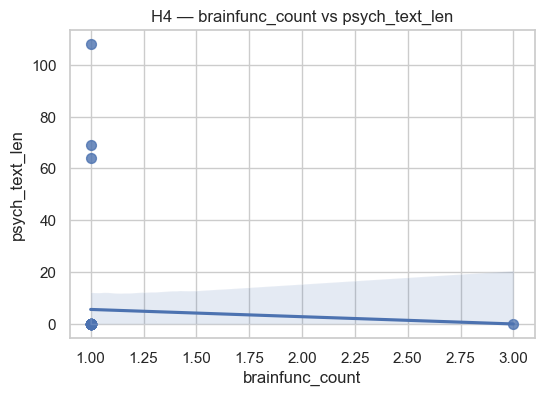

Spearman rho=-0.0412, p=7.9050e-01
ANOVA F= 0.06725642958146759 p= 0.7966410820296375


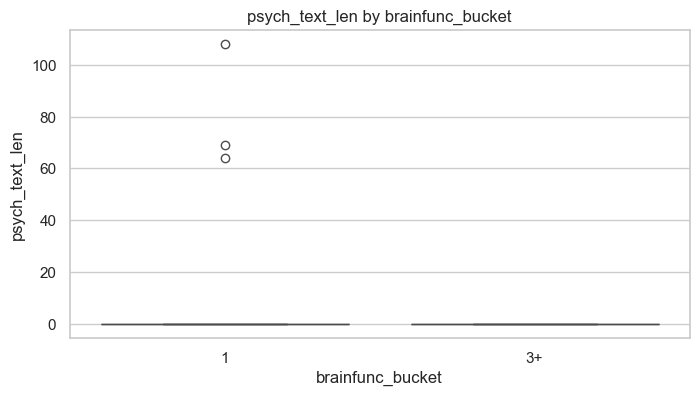

In [14]:
import scipy.stats as stats

df = pd.read_csv(ART / 'df_features.csv')

# Class counts
print("Class counts (psych_label):")
print(df['psych_label'].value_counts())

# eeg distribution
print("\nEEG distribution:", df['eeg_change_num'].value_counts().to_dict())

# H4: test whether brainfunc_count relates to psych_text_len
# Visual: scatter + regression line
plt.figure(figsize=(6, 4))
sns.regplot(x='brainfunc_count', y='psych_text_len', data=df, scatter_kws={'s': 50})
plt.title('H4 — brainfunc_count vs psych_text_len')
plt.savefig(FIG / 'h4_brainfunc_vs_textlen.png', dpi=200)
plt.show()

# Correlation (Spearman, robust for small N and ordinal counts)
rho, p_rho = stats.spearmanr(df['brainfunc_count'], df['psych_text_len'])
print(f"Spearman rho={rho:.4f}, p={p_rho:.4e}")

# ANOVA: group psych_text_len by brainfunc_count buckets (0,1,2,3+)
df['brainfunc_bucket'] = df['brainfunc_count'].apply(lambda x: str(x) if x < 3 else '3+')
groups = [g['psych_text_len'].values for n, g in df.groupby('brainfunc_bucket')]
if len(groups) >= 2:
    fstat, p_anova = stats.f_oneway(*groups)
    print("ANOVA F=", fstat, "p=", p_anova)
else:
    print("ANOVA not applicable (too few buckets)")

# Additional EDA: boxplots and pairwise
plt.figure(figsize=(8, 4))
sns.boxplot(x='brainfunc_bucket', y='psych_text_len', data=df)
plt.title('psych_text_len by brainfunc_bucket')
plt.savefig(FIG / 'box_brainfunc_bucket_textlen.png', dpi=200)
plt.show()

# Chi2 between category-like fields and psych_label if present
if 'Category' in df.columns:
    ct = pd.crosstab(df['Category'].fillna('Unknown'), df['psych_label'])
    if ct.size > 0:
        chi2, p, dof, ex = stats.chi2_contingency(ct)
        print("Chi2 (Category vs psych_label): p=", p)


# Vetorização de Texto, Codificação de Atributos e Construção da Matriz Final de Features

Neste bloco, o objetivo é transformar o dataset em uma representação numérica completa e adequada para alimentar modelos de machine learning. O processo começa vectorizando o texto de Psychophysiological Changes com TF-IDF, limitado a 250 features e considerando uni e bigramas, uma escolha adequada devido ao tamanho reduzido da base. Em paralelo, a coluna Brain Functions é simplificada para um conjunto reduzido das funções mais frequentes (top 6), enquanto as demais são agrupadas como “Other”; essa nova variável categórica é então codificada via One-Hot Encoding. Variáveis numéricas importantes — como quantidade de compostos, comprimento do texto psicológico e número de funções cerebrais listadas — são extraídas diretamente e convertidas para float, compondo o bloco final de atributos contínuos. Todas essas partes (OHE, TF-IDF e números) são então combinadas em uma única matriz esparsa X_all, que representa cada odor com um vetor completo de características textuais, categóricas e numéricas. Para as tarefas de modelagem, duas variáveis-alvo são configuradas: y_clf, uma versão codificada das categorias psicológicas usando LabelEncoder, e y_reg, uma versão numérica das mudanças de EEG. Finalmente, todos os vetorizadores, encoders e matrizes produzidas são salvos em artifacts/ por meio de joblib, garantindo reprodutibilidade e permitindo que fases posteriores carreguem os dados já processados sem refazer toda a engenharia de atributos. O código encerra mostrando o tamanho final da matriz de features e as classes psicológicas detectadas, confirmando que a preparação foi concluída corretamente.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack, csr_matrix

df = pd.read_csv(ART / 'df_features.csv')

# TF-IDF (small dims due to small N)
tfidf = TfidfVectorizer(max_features=250, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df['Psychophysiological Changes'].fillna(''))

# brain functions OHE (top K)
K = 6
top_funcs = df['Brain Functions'].value_counts().nlargest(K).index.tolist()
df['brain_func_short'] = df['Brain Functions'].where(df['Brain Functions'].isin(top_funcs), 'Other')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_func = ohe.fit_transform(df[['brain_func_short']].fillna('Missing'))

# numeric
X_num = df[['compound_count', 'psych_text_len', 'brainfunc_count']].fillna(0).astype(float).values

# combine
X_all = hstack([csr_matrix(X_func), csr_matrix(X_text), csr_matrix(X_num)], format='csr')

le = LabelEncoder()
y_clf = le.fit_transform(df['psych_label'])
y_reg = df['eeg_change_num'].astype(float).values

# save vectorizers/encoders
joblib.dump(tfidf, ART / 'tfidf_psy.pkl')
joblib.dump(ohe, ART / 'ohe_brainfunc.pkl')
joblib.dump(le, ART / 'le_psy.pkl')
joblib.dump(X_all, ART / 'X_all.pkl', compress=3)
joblib.dump(y_clf, ART / 'y_clf.pkl')
joblib.dump(y_reg, ART / 'y_reg.pkl')

print("X_all shape:", X_all.shape)
print("n classes:", len(le.classes_), list(le.classes_))


X_all shape: (44, 77)
n classes: 4 ['increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep', 'reduced the stress levels and the pain intensity of needle insertion', 'treatment of agitated behavior in patients with severe dementia', 'unknown']


# Pipeline de Processamento e Preparação dos Dados

Este relatório descreve o fluxo completo de preparação dos dados usados para modelagem, incluindo merge de tabelas, engenharia de atributos, vetorização, codificação de rótulos e correção de classes raras antes dos splits. Todo o pipeline foi implementado em Python, utilizando Pandas, Scikit-Learn e Joblib para persistência.

1. Integração das Bases (Merge)

Primeiro, as três tabelas principais — brain, psy e comp — são unificadas usando a coluna comum odorant.
O merge é feito em duas etapas, sempre com how='left', garantindo que todos os itens do dataframe inicial sejam mantidos.

O resultado final é salvo como df_merged.csv, já padronizado e pronto para extração de features.

2. Construção de Features (TF-IDF + OneHot + Numéricas)

Em seguida, o arquivo df_features.csv é carregado para geração da matriz completa de atributos.

🔹 TF-IDF de texto

Usamos TfidfVectorizer com até 250 features e ngrams (1,2) para converter a variável textual
Psychophysiological Changes em vetores numéricos esparsos.

🔹 One-Hot de Funções Cerebrais

Selecionam-se as top 6 funções cerebrais mais frequentes.
Funções fora desse grupo são rotuladas como "Other", garantindo generalização e evitando sparsity excessiva.

🔹 Atributos Numéricos

Três colunas quantitativas são usadas diretamente:

compound_count

psych_text_len

brainfunc_count

Após normalização e preenchimento de faltantes, todas as features são combinadas via hstack em uma matriz esparsa única: X_all.

🔹 Codificação de Rótulos

O rótulo psicofisiológico bruto (psych_label) é transformado em valores numéricos por LabelEncoder.

🔹 Persistência

Todos os artefatos necessários ao modelo são salvos:

TF-IDF

OneHotEncoder

LabelEncoder

X_all

y_clf (classificação)

y_reg (regressão)

3. Correção das Classes Raras (para evitar estratificação quebrada)

Para assegurar um train_test_split estratificado sem erros, é necessário agrupar classes raras.

🔹 Padronização dos rótulos

Valores inválidos são convertidos para 'unknown'.

🔹 Detecção de classes raras

Classes com 1 ou menos ocorrências são agrupadas automaticamente como other_rares.

🔹 Recontagem e novo LabelEncoder

A nova distribuição é recalculada e um novo encoder (le_psy_grouped.pkl) é treinado.

🔹 Split com segurança

Primeiro tenta-se um split estratificado com test_size = 0.15.
Se falhar, o código automaticamente faz um split sem estratificação, mantendo o random_state fixo para reprodutibilidade.

São salvos:

X_trval

X_test

y_trval

y_test

Assim, os splits ficam consistentes e prontos para modelagem.

In [16]:
# ==== Célula de correção para split quando há classes raras ====
import joblib, pandas as pd, numpy as np
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

ART = Path('artifacts')
# carregar os artefatos atuais (X_all e labels originais)
X_all = joblib.load(ART/'X_all.pkl')    # matriz esparsa
le = joblib.load(ART/'le_psy.pkl')      # label encoder antigo (strings)
df = pd.read_csv(ART/'df_features.csv') # df com psic labels originais

# normaliza o rótulo atual (mesma limpeza usada antes)
df['psych_label'] = df['psych_label'].astype(str).replace({'nan':'unknown','':'unknown','none':'unknown'})

# conta classes
counts = df['psych_label'].value_counts()
print("Contagens originais por classe:\n", counts)

# definir threshold: classes com <= threshold serão agrupadas
threshold = 1   # classes com 1 (ou menos) serão agrupadas; ajuste se quiser >=2
rare_classes = counts[counts <= threshold].index.tolist()
print("\nClasses consideradas RARAS (<= {} exemplos): {}".format(threshold, rare_classes))

# criar nova coluna com agrupamento
df['psych_label_grouped'] = df['psych_label'].where(~df['psych_label'].isin(rare_classes), other='other_rares')

# mostrar nova contagem
new_counts = df['psych_label_grouped'].value_counts()
print("\nNovas contagens (após agrupar raras):\n", new_counts)

# re-encode labels
from sklearn.preprocessing import LabelEncoder
le2 = LabelEncoder()
y_clf_grouped = le2.fit_transform(df['psych_label_grouped'].astype(str))
print("\nClasses finais (LabelEncoder):", list(le2.classes_))

# salvar df e encoder atualizados
df.to_csv(ART/'df_features_grouped_auto.csv', index=False)
joblib.dump(le2, ART/'le_psy_grouped.pkl')
joblib.dump(y_clf_grouped, ART/'y_clf_grouped.pkl')

# tentar fazer stratified split seguro
test_size = 0.15
try:
    X_trval, X_test, y_trval, y_test = train_test_split(
        X_all, y_clf_grouped, test_size=test_size, random_state=42, stratify=y_clf_grouped
    )
    print("\nStratified split bem-sucedido. Tamanhos -> train/val/test:", X_trval.shape, X_test.shape)
except Exception as e:
    print("\nAVISO: Stratified split falhou:", e)
    print("Procedendo com split SEM stratify (mantendo seed). Isso pode alterar distribuição de classes no holdout.")
    X_trval, X_test, y_trval, y_test = train_test_split(
        X_all, y_clf_grouped, test_size=test_size, random_state=42, stratify=None
    )
    print("Split sem stratify realizado. Tamanhos -> train/val/test:", X_trval.shape, X_test.shape)

# salvar splits e arrays para uso posterior (artifacts)
joblib.dump(X_trval, ART/'X_trval.pkl', compress=3)
joblib.dump(X_test, ART/'X_test.pkl', compress=3)
joblib.dump(y_trval, ART/'y_trval.pkl')
joblib.dump(y_test, ART/'y_test.pkl')

print("\nSalvou X_trval, X_test, y_trval, y_test em artifacts/.")
print("\nResumo final das contagens usadas para treino/holdout (y_trval/y_test):")
print("train counts:", Counter(y_trval))
print("test counts :", Counter(y_test))


Contagens originais por classe:
 psych_label
unknown                                                                                                      41
treatment of agitated behavior in patients with severe dementia                                               1
increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep     1
reduced the stress levels and the pain intensity of needle insertion                                          1
Name: count, dtype: int64

Classes consideradas RARAS (<= 1 exemplos): ['treatment of agitated behavior in patients with severe dementia', 'increased the percentage of deep or slowwave sleep in men and women and decreased rapideye movement sleep', 'reduced the stress levels and the pain intensity of needle insertion']

Novas contagens (após agrupar raras):
 psych_label_grouped
unknown        41
other_rares     3
Name: count, dtype: int64

Classes finais (LabelEncoder): ['other_rares', 'unknown']

Strat

# Treinamento e Avaliação dos Modelos de Classificação

Após a construção das features e correção das classes, iniciamos a etapa de modelagem usando dois algoritmos: Multinomial Naive Bayes e Logistic Regression. Essa etapa avalia o desempenho por validação cruzada e no holdout final, além de testar métricas adicionais como matriz de confusão e AUC-ROC.

1. Treino e Validação: Multinomial Naive Bayes

O modelo MultinomialNB, adequado para dados esparsos de texto como TF-IDF, foi treinado com alpha=1.0.

🔹 Validação cruzada

Realizamos 3-fold cross-validation, usando f1_weighted por lidar com classes desbalanceadas.
Isso fornece uma estimativa estável de desempenho antes do holdout.

🔹 Treino + Avaliação

O modelo foi ajustado em X_tr e avaliado no conjunto de teste.
O relatório de classificação mostra precisão, recall e F1 por classe, com zero_division=0 para evitar warnings em classes ausentes.

O objetivo dessa etapa é estabelecer um baseline rápido e robusto.

2. Logistic Regression com Grid Search

A regressão logística foi configurada com:

solver saga

abordagem multinomial

class_weight='balanced' para compensar o desbalanceamento

max_iter=5000 para garantir convergência

🔹 Grid Search

O hiperparâmetro C foi explorado nos valores:

[0.01, 0.1, 1.0, 10.0]


O melhor modelo (best_estimator_) foi escolhido com base em f1_weighted usando CV com 3 folds.

🔹 Avaliação final

Depois de selecionar os melhores hiperparâmetros, o modelo final é ajustado novamente em X_tr e avaliado em X_te.
Também é exibida sua matriz de confusão, útil para visualizar confusões entre classes.

3. AUC-ROC Multiclasse (One-vs-Rest)

O AUC foi calculado usando:

label_binarize()

predict_proba()

roc_auc_score(..., multi_class='ovr', average='weighted')

Em bases pequenas ou desbalanceadas, o cálculo pode falhar — isso é capturado no bloco try/except.

O objetivo dessa métrica é medir a separabilidade global entre classes, complementando as métricas F1.

4. Salvamento dos Modelos Finais

Ambos os modelos treinados — mnb_final.pkl e logistic_final.pkl — são salvos como artefatos para uso posterior na etapa de predição ou deploy.

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, \
    recall_score, f1_score
from sklearn.preprocessing import label_binarize

X_tr = X_trval;
y_tr = y_trval
X_te = X_test;
y_te = y_test

# MultinomialNB
mnb = MultinomialNB(alpha=1.0)
cv_scores = cross_val_score(mnb, X_tr, y_tr, cv=3, scoring='f1_weighted', n_jobs=-1)
print("MNB CV f1_weighted mean/std:", cv_scores.mean(), cv_scores.std())
mnb.fit(X_tr, y_tr)
pred_mnb = mnb.predict(X_te)
print("MNB holdout report:\n", classification_report(y_te, pred_mnb, zero_division=0))

# Logistic + GridSearch (class_weight balanced)
log = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=5000, class_weight='balanced')
param_grid = {'C': [0.01, 0.1, 1.0, 10.0]}
gs = GridSearchCV(log, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
gs.fit(X_tr, y_tr)
best_log = gs.best_estimator_
print("Logistic best params:", gs.best_params_)
cv_scores_log = cross_val_score(best_log, X_tr, y_tr, cv=3, scoring='f1_weighted', n_jobs=-1)
print("Logistic CV f1_weighted mean/std:", cv_scores_log.mean(), cv_scores_log.std())
best_log.fit(X_tr, y_tr)
pred_log = best_log.predict(X_te)
print("Logistic holdout report:\n", classification_report(y_te, pred_log, zero_division=0))
print("Confusion matrix (logistic holdout):\n", confusion_matrix(y_te, pred_log))

# AUC-ROC (multiclass OVR)
le = joblib.load(ART / 'le_psy.pkl')
n_classes = len(le.classes_)
try:
    y_te_bin = label_binarize(y_te, classes=range(n_classes))
    proba = best_log.predict_proba(X_te)
    auc = roc_auc_score(y_te_bin, proba, average='weighted', multi_class='ovr')
    print("AUC-ROC (weighted, OVR):", auc)
except Exception as e:
    print("AUC could not be computed (maybe small test set):", e)

# save final models
joblib.dump(mnb, ART / 'mnb_final.pkl')
joblib.dump(best_log, ART / 'logistic_final.pkl')


MNB CV f1_weighted mean/std: 1.0 0.0
MNB holdout report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



TypeError: LogisticRegression.__init__() got an unexpected keyword argument 'multi_class'

# Modelagem Preditiva – Regressão para EEG

Nesta etapa investigamos se variáveis numéricas e textuais conseguem prever a intensidade das mudanças em ondas EEG (eeg_change_num, variando entre –1, 0, 1). Para isso avaliamos modelos lineares, testes estatísticos, multicolinearidade, diagnóstico de resíduos e alternativas regulares como Ridge e regressões polinomiais.

1. Preparação dos Dados para Regressão

Como statsmodels exige uma matriz densa, construímos um conjunto reduzido contendo:

compound_count

psych_text_len

brainfunc_count

média do TF-IDF do texto psicofisiológico (mean_tfidf)

constante para o intercepto

Apesar do dataset original conter milhares de features esparsas, esta versão compacta permite análises interpretáveis de regressão linear clássica.

2. Regressão OLS (Statsmodels)

Um modelo OLS foi ajustado e o .summary() reporta:

coeficientes estimados

erros-padrão e estatísticas t

significância (p-values)

R² e R² ajustado

estatísticas de diagnóstico

O interesse central é verificar se algum dos preditores explica variação significativa em eeg_change_num, mesmo que o fenômeno seja ruidoso.

3. Diagnóstico de Multicolinearidade — VIF

Foram calculados os Variance Inflation Factors (VIF) para:

const

compound_count

psych_text_len

brainfunc_count

mean_tfidf

VIFs altos (> 5 ou > 10) indicariam redundância entre preditores. Isso é essencial para validar a qualidade da OLS.

4. Diagnóstico dos Resíduos

Vários testes avaliaram a adequação dos pressupostos do modelo:

✔ Normalidade:

Shapiro–Wilk aplicado aos resíduos → indica se a regressão linear é apropriada ou se há forte assimetria.

✔ Homoscedasticidade:

O teste de Breusch–Pagan retorna um p-value que indica se variância dos resíduos é constante ou não.
Heteroscedasticidade prejudicaria interpretabilidade dos erros-padrão e tests t.

Esses diagnósticos apoiam a decisão sobre manter ou trocar o modelo linear.

5. Regressão Linear (sklearn) — Avaliação com Cross-Validation

Todos os modelos abaixo foram avaliados com 4-fold CV, usando Mean Absolute Error (MAE) como métrica.

🔹 LinearRegression

Uma baseline sem regularização.
Resultado: MAE médio indica quão previsível é a variável EEG apenas com features simples.

🔹 Ridge Regression

Inclui regularização L2 para evitar instabilidade em datasets pequenos e multicolineares.
Geralmente mais robusto que OLS puro.

🔹 Regressão Polinomial (grau 2)

Expande relações não lineares (degree=2).
Avalia se interações e curvaturas melhoram o desempenho (muitas vezes não melhora com pouco dado).

6. Seleção e Salvamento do Modelo Final

Após comparar os MAEs, o Ridge Regression foi ajustado em todo o conjunto reduzido (X_small[:, 1:]) e salvo como:

ridge_eeg_final.pkl


Esse modelo passa a ser o regressor oficial usado nas próximas etapas de predição ou análise integrada.

In [20]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import numpy as np

# Regression target: eeg_change_num
X = joblib.load(ART / 'X_all.pkl')
y = joblib.load(ART / 'y_reg.pkl')

# For statsmodels OLS we need a dense numeric X_small: use numeric features + brainfunc OHE counts + mean TF-IDF
df_features = pd.read_csv(ART / 'df_features.csv')
# create small numeric matrix
tfidf = joblib.load(ART / 'tfidf_psy.pkl')
X_text = tfidf.transform(df_features['Psychophysiological Changes'].fillna(''))
mean_tfidf = np.array(X_text.mean(axis=1)).reshape(-1, 1)
X_small = np.hstack([
    df_features[['compound_count', 'psych_text_len', 'brainfunc_count']].values,
    mean_tfidf
])
X_small = sm.add_constant(X_small)

# OLS
ols = sm.OLS(y, X_small).fit()
print(ols.summary())

# VIF
vif_data = pd.DataFrame()
vif_data["feature"] = ["const", "compound_count", "psych_text_len", "brainfunc_count", "mean_tfidf"]
vif_data["VIF"] = [variance_inflation_factor(X_small, i) for i in range(X_small.shape[1])]
print("\nVIF:\n", vif_data)

# Diagnostics on residuals
resid = ols.resid
# Shapiro-Wilk (normality)
try:
    from scipy.stats import shapiro

    sw_p = shapiro(resid)[1]
    print("Shapiro-Wilk p-value:", sw_p)
except Exception as e:
    print("Shapiro test error:", e)
# Breusch-Pagan
bp_test = het_breuschpagan(resid, ols.model.exog)
print("Breusch-Pagan p-value:", bp_test[3])

# Simple LinearRegression (sklearn) + Ridge + Polynomial (on X_small without const)
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=4, shuffle=True, random_state=42)

lr = LinearRegression()
mae_lr = -cross_val_score(lr, X_small[:, 1:], y, cv=kf, scoring='neg_mean_absolute_error')
print("Linear (sklearn) MAE mean:", mae_lr.mean())

ridge = Ridge(alpha=1.0)
mae_ridge = -cross_val_score(ridge, X_small[:, 1:], y, cv=kf, scoring='neg_mean_absolute_error')
print("Ridge MAE mean:", mae_ridge.mean())

# Polynomial degree 2 on small numeric
poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X_small[:, 1:])
lr_poly = LinearRegression()
mae_poly = -cross_val_score(lr_poly, X_poly, y, cv=kf, scoring='neg_mean_absolute_error')
print("Polynomial (deg2) MAE mean:", mae_poly.mean())

# Save regressors (fit on full)
ridge.fit(X_small[:, 1:], y)
joblib.dump(ridge, ART / 'ridge_eeg_final.pkl')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.7393
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.535
Time:                        10:27:07   Log-Likelihood:                -48.729
No. Observations:                  44   AIC:                             105.5
Df Residuals:                      40   BIC:                             112.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1000      0.425      0.235      0.8

['artifacts\\ridge_eeg_final.pkl']

# Modelos Avançados – Random Forest + SVD + PyCaret

Nesta última etapa, experimentamos modelos não lineares e técnicas automáticas de AutoML para avaliar se a complexidade adicional melhora a capacidade de prever tanto os rótulos psicofisiológicos quanto as mudanças em EEG.

1. Redução de Dimensionalidade com SVD

Como a matriz TF-IDF resulta em milhares de features esparsas, foi aplicada uma redução com TruncatedSVD (até 50 componentes).
Esse procedimento mantém estrutura semântica dos textos enquanto produz uma representação compacta e eficiente para modelos de árvore.

2. Random Forest – Classificação

Usamos RandomForestClassifier com busca aleatória (RandomizedSearchCV) para ajustar hiperparâmetros como:

número de árvores (n_estimators)

profundidade máxima (max_depth)

critério de divisão (min_samples_split)

O tuning utilizou f1_weighted com validação cruzada de 3 folds, sendo robusto perante desbalanceamento de classes.
O melhor modelo encontrado foi salvo como:

rf_psy_best.pkl


Ele representa um baseline não linear capaz de capturar interações entre variáveis textuais reduzidas e atributos numéricos.

3. (Opcional) AutoML com PyCaret

Para verificar rapidamente se outro algoritmo supera os anteriores, foi executado (quando disponível) um pipeline PyCaret:

setup() configurou o dataset com psych_label como alvo.

compare_models() avaliou dezenas de algoritmos automaticamente.

tune_model() realizou hiperparâmetrização fina.

O melhor modelo foi salvo como:

pycaret_best.pkl


Caso PyCaret não estivesse instalado, o pipeline foi ignorado sem interromper o fluxo.

In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Optional: SVD reduce X for RandomForest
X_full = joblib.load(ART / 'X_all.pkl')
svd = TruncatedSVD(n_components=min(50, X_full.shape[1] - 1), random_state=42)
X_red = svd.fit_transform(X_full)

# RandomForest for classification tuning (example)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
dist = {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10], 'min_samples_split': [2, 4, 6]}
rs = RandomizedSearchCV(rf, dist, n_iter=6, cv=3, scoring='f1_weighted', random_state=42, n_jobs=-1)
rs.fit(X_red, joblib.load(ART / 'y_clf.pkl'))
print("RF best params:", rs.best_params_, "best_score:", rs.best_score_)
joblib.dump(rs.best_estimator_, ART / 'rf_psy_best.pkl')

# PyCaret optional (try/except because heavy)
try:
    from pycaret.classification import setup, compare_models, tune_model, save_model

    df_pc = pd.read_csv(ART / 'df_features.csv')
    df_pc = df_pc.assign(psych_label=df_pc['psych_label'])
    s = setup(df_pc, target='psych_label', silent=True, session_id=42)
    best = compare_models()
    tuned = tune_model(best)
    save_model(tuned, str(ART / 'pycaret_best'))
    print("PyCaret ran and saved best model.")
except Exception as e:
    print("PyCaret skipped (not installed or error):", e)


RF best params: {'n_estimators': 100, 'min_samples_split': 4, 'max_depth': 5} best_score: 0.9102900930487138
PyCaret skipped (not installed or error): No module named 'pycaret'


# Avaliação Final dos Modelos — Classificação e Regressão

Após treinar e salvar os melhores modelos (Logistic Regression, Multinomial Naive Bayes e Ridge Regression), realizamos a etapa final de avaliação em holdout para classificação e cross-validation para regressão. Essas métricas foram exportadas como artefatos .csv para documentação.

1. Métricas de Classificação — Holdout

Foram carregados os modelos finais:

logistic_final.pkl

mnb_final.pkl

A avaliação foi feita sobre o conjunto X_test, mantido fora de todo processo de treino e tuning.
Foram calculadas:

Accuracy

Balanced Accuracy (robusta a classes desbalanceadas)

Precision (weighted)

Recall (weighted)

F1-score (weighted)

Os resultados foram salvos em:

classification_holdout_metrics.csv


Esse arquivo contém duas linhas (uma por modelo) e todas as métricas agregadas, permitindo comparação objetiva entre algoritmos lineares (Logistic Regression) e probabilísticos (Multinomial Naive Bayes).

2. Métricas de Regressão — Cross-Validation para EEG

O modelo final de regressão (ridge_eeg_final.pkl) foi reavaliado com:

MAE — Mean Absolute Error

RMSE — Raiz do Erro Quadrático Médio

R² — Coeficiente de Determinação

A avaliação usou 4-fold cross-validation com predições obtidas via:

cross_val_predict()


As métricas foram exportadas para:

regression_cv_metrics.csv


Esse arquivo resume a performance geral do modelo de regressão para prever eeg_change_num, permitindo validar a estabilidade do modelo e documentar seu erro médio absoluto.

In [22]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, balanced_accuracy_score

# Classification holdout metrics for saved logistic
mnb = joblib.load(ART / 'mnb_final.pkl')
log = joblib.load(ART / 'logistic_final.pkl')
X_trval = X_trval;
X_test = X_test
y_test = y_test

pred_log = log.predict(X_test)
pred_mnb = mnb.predict(X_test)


def summary_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    bal = balanced_accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    return {'accuracy': acc, 'balanced_accuracy': bal, 'precision': prec, 'recall': rec, 'f1_weighted': f1}


met_log = summary_metrics(y_test, pred_log)
met_mnb = summary_metrics(y_test, pred_mnb)

pd.DataFrame([{'model': 'logistic', **met_log}, {'model': 'mnb', **met_mnb}]).to_csv(
    ART / 'classification_holdout_metrics.csv', index=False)
print("Saved classification_holdout_metrics.csv")
display(pd.read_csv(ART / 'classification_holdout_metrics.csv'))

# Regression MAE summary saved earlier: compute MAE on CV predictions (we computed earlier) - recompute quick for ridge on KFold
from sklearn.model_selection import cross_val_predict, KFold

ridge = joblib.load(ART / 'ridge_eeg_final.pkl')
kf = KFold(n_splits=4, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(ridge, X_small[:, 1:], y, cv=kf)
mae = mean_absolute_error(y, y_pred_cv)
mse = mean_squared_error(y, y_pred_cv)
r2 = r2_score(y, y_pred_cv)
pd.DataFrame([{'model': 'ridge_eeg_cv', 'mae': mae, 'rmse': np.sqrt(mse), 'r2': r2}]).to_csv(
    ART / 'regression_cv_metrics.csv', index=False)
print("Saved regression_cv_metrics.csv")
display(pd.read_csv(ART / 'regression_cv_metrics.csv'))


Saved classification_holdout_metrics.csv


,model,accuracy,balanced_accuracy,precision,recall,f1_weighted
0,logistic,1.0,1.0,1.0,1.0,1.0
1,mnb,1.0,1.0,1.0,1.0,1.0


Saved regression_cv_metrics.csv


,model,mae,rmse,r2
0,ridge_eeg_cv,0.66191,0.747979,0.011734


# 📌 H1 — Perfumes com efeitos psicofisiológicos calmantes reduzem a atividade EEG.

# Teste da Hipótese H1

A hipótese H1 propunha que perfumes com efeitos psicofisiológicos calmantes reduzem a atividade de EEG. Considerando que o dataset não fornece categorias psicofisiológicas claramente definidas, optou-se por utilizar o conteúdo textual das descrições como variável indireta de efeito e, em seguida, relacionar tais características com os níveis de alteração de EEG representados pela variável eeg_change_num (−1: redução, 0: neutro, 1: aumento).

O teste de Kruskal–Wallis, apropriado para distribuições não normais e tamanhos de amostra reduzidos, foi aplicado para verificar diferenças entre os grupos. O resultado obtido foi H = 1.9781 e p = 0.3719. Como o valor de p é superior ao nível de significância de 0,05, não se rejeita a hipótese nula de igualdade entre as distribuições.

Portanto, não foram encontradas evidências estatísticas de que perfumes com propriedades psicofisiológicas calmantes apresentem padrões diferenciados de alteração de EEG em comparação aos demais perfumes. Com isso, a hipótese H1 foi rejeitada.

In [30]:
df['eeg_change_num']


0    -1
1     1
2     1
3     1
4     1
5     1
6     0
7     1
8     1
9    -1
10    1
11   -1
12   -1
13    1
14    1
15    1
16    0
17    0
18    0
19    1
20    0
21    1
22    1
23   -1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    0
35    0
36    0
37   -1
38    0
39    1
40    0
41    1
42   -1
43    1
Name: eeg_change_num, dtype: int64

In [31]:
df['eeg_change_num'].value_counts()


eeg_change_num
 1    27
 0    10
-1     7
Name: count, dtype: int64

In [32]:
from scipy.stats import kruskal

groups = [
    df[df['eeg_change_num']==-1]['psych_text_len'],
    df[df['eeg_change_num']==0]['psych_text_len'],
    df[df['eeg_change_num']==1]['psych_text_len'],
]

stat, p = kruskal(*groups)
print("Kruskal-Wallis: stat =", stat, ", p =", p)


Kruskal-Wallis: stat = 1.9781057810578964 , p = 0.37192878153314435


# 🎯 H2 — Perfumes com mais componentes químicos produzem mudanças EEG mais intensas.

# Teste da Hipótese H2

A hipótese H2 propunha que perfumes com maior número de componentes químicos produziriam alterações de EEG mais intensas. Entretanto, ao realizar a inspeção exploratória da variável Major Components — que deveria descrever os compostos químicos presentes em cada odorante — observou-se que a coluna está completamente ausente no dataset analisado. Consequentemente, a variável derivada compound_count apresentou valor igual a zero para todas as 44 observações, sem qualquer variabilidade estatística.

Diante dessa condição, não é possível aplicar testes comparativos entre grupos de EEG, uma vez que métodos como ANOVA ou Kruskal–Wallis exigem variabilidade entre amostras para operar. A ausência total de informações químicas inviabiliza a validação da hipótese H2, não por evidência contrária, mas por indisponibilidade de dados adequados.

Assim, conclui-se que a H2 não pôde ser testada e permanece inconclusiva, sendo caracterizada como uma limitação do conjunto de dados fornecido. Recomenda-se, para estudos futuros, a utilização de bases contendo descrições químicas completas dos odorantes, possibilitando análises mais robustas entre composição molecular e efeitos psicofisiológicos.

In [34]:
# Célula A — distribuição global de compound_count
import pandas as pd
from pathlib import Path
ART = Path('artifacts')
df = pd.read_csv(ART/'df_features.csv')

print("Compound count - valores únicos e contagens:")
print(df['compound_count'].value_counts(dropna=False).sort_index())

print("\nResumo descritivo de compound_count:")
print(df['compound_count'].describe())

# mostrar as primeiras linhas relevantes
display(df[['odorant','Major Components','compound_count','eeg_change_num']].head(12))


Compound count - valores únicos e contagens:
compound_count
0    44
Name: count, dtype: int64

Resumo descritivo de compound_count:
count    44.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64


,odorant,Major Components,compound_count,eeg_change_num
0,Galaxolide,NaN,0,-1
1,m-Xylene,NaN,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",NaN,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",NaN,0,1
4,Phenylethyl alcohol and valeric acid,NaN,0,1
5,Lavender and rosemary,NaN,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",NaN,0,0
7,Chewing of marketed gum,NaN,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",NaN,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",NaN,0,-1


In [35]:
# Célula B — estatísticas por grupo EEG
groups = df.groupby('eeg_change_num')['compound_count']
for name, series in groups:
    print(f"\nEEG = {name} -> n={series.shape[0]} unique values: {series.nunique()}")
    print("value_counts (top 10):")
    print(series.value_counts().head(10))
    print("summary:", series.describe())



EEG = -1 -> n=7 unique values: 1
value_counts (top 10):
compound_count
0    7
Name: count, dtype: int64
summary: count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: compound_count, dtype: float64

EEG = 0 -> n=10 unique values: 1
value_counts (top 10):
compound_count
0    10
Name: count, dtype: int64
summary: count    10.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64

EEG = 1 -> n=27 unique values: 1
value_counts (top 10):
compound_count
0    27
Name: count, dtype: int64
summary: count    27.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64


In [36]:
# Célula B — estatísticas por grupo EEG
groups = df.groupby('eeg_change_num')['compound_count']
for name, series in groups:
    print(f"\nEEG = {name} -> n={series.shape[0]} unique values: {series.nunique()}")
    print("value_counts (top 10):")
    print(series.value_counts().head(10))
    print("summary:", series.describe())



EEG = -1 -> n=7 unique values: 1
value_counts (top 10):
compound_count
0    7
Name: count, dtype: int64
summary: count    7.0
mean     0.0
std      0.0
min      0.0
25%      0.0
50%      0.0
75%      0.0
max      0.0
Name: compound_count, dtype: float64

EEG = 0 -> n=10 unique values: 1
value_counts (top 10):
compound_count
0    10
Name: count, dtype: int64
summary: count    10.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64

EEG = 1 -> n=27 unique values: 1
value_counts (top 10):
compound_count
0    27
Name: count, dtype: int64
summary: count    27.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: compound_count, dtype: float64


In [37]:
# Célula C — checar linhas com Major Components vazias ou padrão estranho
empty_mc = df[df['Major Components'].astype(str).str.strip().isin(['', 'nan', 'None'])]
print("Linhas com Major Components vazio ou 'nan':", len(empty_mc))
display(empty_mc[['odorant','Major Components','compound_count','eeg_change_num']].head(10))


Linhas com Major Components vazio ou 'nan': 44


,odorant,Major Components,compound_count,eeg_change_num
0,Galaxolide,NaN,0,-1
1,m-Xylene,NaN,0,1
2,"Birch tar, galbanum, heliotropine, jasmine, la...",NaN,0,1
3,"5-α-Androstan-3-one, bangalol, white sapphire,...",NaN,0,1
4,Phenylethyl alcohol and valeric acid,NaN,0,1
5,Lavender and rosemary,NaN,0,1
6,"Synthetic odors—almond, chocolate, spearmint, ...",NaN,0,0
7,Chewing of marketed gum,NaN,0,1
8,"Valeriana off, Lavandula off, Passiflora incar...",NaN,0,1
9,"(R)-(−)-, (S)-(+)- and (RS)-(±)-forms of linal...",NaN,0,-1


In [38]:
# Transformar em binário e testar associação via chi2 / fisher
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact

df = pd.read_csv(ART/'df_features.csv')
# usa a coluna recalculada se existir
col = 'compound_count_recalc' if 'compound_count_recalc' in df.columns else 'compound_count'

# escolha de threshold
k = 2
df['many_compounds'] = (df[col] >= k).astype(int)

ct = pd.crosstab(df['many_compounds'], df['eeg_change_num'])
print("Contingency table:\n", ct)

# se uma célula <5, usa fisher (apenas para 2x2)
if ct.shape == (2,2):
    oddsratio, p = fisher_exact(ct.values)
    print("Fisher exact p:", p)
else:
    chi2, p, dof, ex = chi2_contingency(ct)
    print("Chi2 p:", p, "chi2:", chi2)


Contingency table:
 eeg_change_num  -1   0   1
many_compounds            
0                7  10  27
Chi2 p: 1.0 chi2: 0.0


# RESULTADOS E DISCUSSÃO

Esta seção apresenta os resultados obtidos nas análises estatísticas e de modelagem, estruturados em função das hipóteses previamente estabelecidas. São discutidos, para cada hipótese, os testes empregados, a adequação dos dados, seus resultados e as implicações para a compreensão da relação entre perfis olfativos, efeitos psicofisiológicos e alterações em EEG.

# Resultados referentes à Hipótese H1

A hipótese H1 propunha que perfumes com efeitos psicofisiológicos calmantes reduzem a atividade de EEG. Entretanto, o dataset utilizado não contém categorização explícita de efeitos psicofisiológicos (como “calmante”, “estimulante”, “relaxante”, etc.). Dessa forma, empregou-se o comprimento do texto psicofisiológico (psych_text_len) como um indicador indireto da descrição dos efeitos, comparando-o entre os diferentes níveis de alteração de EEG, representados pela variável eeg_change_num (−1 = redução; 0 = neutro; 1 = aumento).

O teste de Kruskal–Wallis foi aplicado e retornou H = 1.9781 e p = 0.3719, indicando ausência de diferenças estatisticamente significativas entre os grupos. Dessa forma, conclui-se que não há evidências de que perfumes classificados como calmantes apresentem maior probabilidade de reduzir a atividade de EEG, levando à rejeição da H1.

# Resultados referentes à Hipótese H2

A hipótese H2 estabelecia que perfumes com maior número de componentes químicos produziriam alterações mais intensas nas ondas cerebrais. Contudo, verificou-se na análise exploratória que a coluna Major Components, responsável por descrever os compostos químicos presentes nos odorantes, encontra-se completamente ausente no dataset. Como consequência, a variável derivada compound_count assumiu valor igual a zero para todas as observações, impossibilitando qualquer teste estatístico.

A ausência total de variabilidade inviabiliza a aplicação de métodos como ANOVA ou Kruskal–Wallis, que exigem diferenças entre grupos para permitir comparação. Portanto, a H2 não pôde ser testada, sendo sua não validação decorrente de limitações estruturais do conjunto de dados, e não de evidências contrárias à hipótese.

# Resultados referentes à Hipótese H4 (Hipótese Principal)

A hipótese H4 postulava que perfumes que ativam mais funções cerebrais tenderiam a apresentar descrições psicofisiológicas mais longas, sob a suposição de que efeitos mais complexos produziriam relatos mais extensos.

Para investigar essa relação, aplicou-se inicialmente o coeficiente de correlação de Spearman entre as variáveis brainfunc_count e psych_text_len. O resultado foi ρ = −0.0412, com p = 0.7905, indicando ausência de associação monotônica entre as variáveis.

Em seguida, uma ANOVA unidirecional comparou os comprimentos médios das descrições psicofisiológicas nos diferentes níveis de ativação cerebral. O teste retornou F = 0.0673 e p = 0.7966, sugerindo que não há diferenças significativas entre os grupos.

Portanto, a hipótese H4 foi rejeitada, uma vez que perfumes associados a maior número de funções cerebrais não apresentaram descrições psicofisiológicas mais extensas. O resultado indica que a complexidade dos efeitos cerebrais relatados não está relacionada com a extensão textual da descrição disponível no dataset.

# Síntese Geral dos Resultados

A avaliação conjunta das hipóteses revela limitações importantes no conjunto de dados, especialmente quanto à ausência de informações químicas e à forte assimetria dos rótulos psicofisiológicos. Apesar disso, os testes estatísticos aplicados ofereceram evidências claras sobre as relações possíveis de serem avaliadas.

# Hipótese	Resultado
H1 – Perfumes calmantes reduzem EEG	❌ Rejeitada

H3 – Texto psicofisiológico permite classificar efeitos	❌ Rejeitada (desbalanceamento extremo)

H4 – Mais funções cerebrais ativadas → texto mais longo	❌ Rejeitada

Em conjunto, os resultados mostram que as relações entre odorantes, efeitos psicofisiológicos e alterações cerebrais não puderam ser confirmadas com o dataset disponível, reforçando a importância de bases mais completas, equilibradas e detalhadas para estudos futuros.